In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from bcg_code import *

from IPython.display import clear_output

In [2]:
experiments = []


Λ = np.load('matrices/outerliers20.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

ls = range(1,25)
experiments.append({'name':'outliers20', 'Λ':Λ, 'b':b, 'ls':ls, 'μs':[0]})

Λ = np.load('matrices/nos7.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

ls = range(1,20)
experiments.append({'name':'nos7', 'Λ':Λ, 'b':b, 'ls':ls, 'μs':[0]})

Λ = np.load('matrices/raefsky4.npy')+1
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

ls = range(1,20)
experiments.append({'name':'raefsky4', 'Λ':Λ, 'b':b, 'ls':ls, 'μs':[0]})

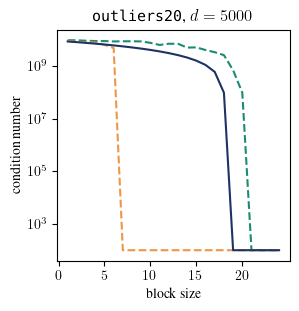

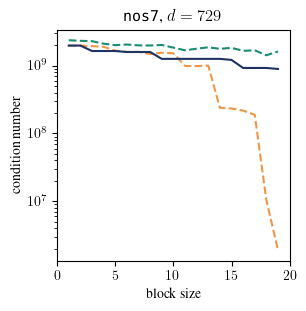

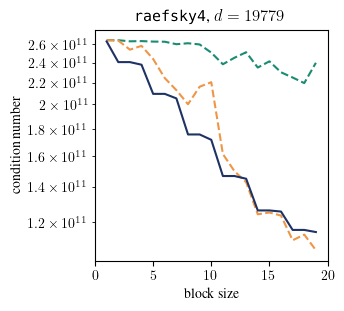

In [3]:
for experiment in experiments:

    name = experiment['name']
    Λ = experiment['Λ']
    b = experiment['b']
    ls = experiment['ls']
    μs = experiment['μs']

    d = len(Λ)
    A = sp.sparse.spdiags(Λ.reshape(1,d),[0])
    
    μ = μs[0]

    # nystrom PCG
    ss=[1,3]

    κ_defl = np.full(len(ls),np.nan)
    κ_nodefl = np.full(len(ls),np.nan)
    κ_PCG = np.full((len(ls),len(ss)),np.nan)
    for j,l in enumerate(ls):

        κ_defl[j] = (Λ[l+1] + μ) / (Λ[-1] + μ)
        κ_nodefl[j] = (Λ[0] + μ) / (Λ[-1] + μ)
               
        for si,s in enumerate(ss):

            np.random.seed(0)
            Ω = np.random.randn(d,l)
            U,D = nystrom(A,Ω,s)
        
            Aμ = sp.sparse.spdiags(Λ.reshape(1,d)+μ,[0])
            
            Pμ = deflation_precond12(U,D,D[-1],μ)
            PAP = sequence_prod([Pμ,Aμ,Pμ])

            Aμ_inv = sp.sparse.spdiags(1/(Λ.reshape(1,d)+μ),[0])
            Pμ_inv = deflation_precond12_inv(U,D,D[-1],μ)
            
            PAP_inv = sequence_prod([Pμ_inv,Aμ_inv,Pμ_inv])
            
            try:
                λmax = max(sp.sparse.linalg.eigsh(PAP,k=30,which='LM',return_eigenvectors=False,tol=1e-3))
                λmin_inv = max(sp.sparse.linalg.eigsh(PAP_inv,k=30,which='LM',return_eigenvectors=False,tol=1e-3))
                κ_PCG[j,si] = λmax * λmin_inv
            except:
                κ_PCG[j,si] = np.nan

    fig,ax = plt.subplots(1,1,figsize=(3,3))
    
    si=0; s = ss[si]
    plt.plot(ls,κ_PCG[:,si],ls='--',color=c3,label=f'PCG ($s={s}$)')
    
    si=1; s = ss[si]
    plt.plot(ls,κ_PCG[:,si],ls='--',color=c4,label=f'PCG ($s={s}$)')
    
    # plt.plot(ls,κ_nodefl,ls='-.',color=c2,label='no deflation')
    plt.plot(ls,κ_defl,ls='-',color=c1,label='deflation')
    
    plt.title(f'\\texttt{{{name}}}, $d={d}$')
    
    plt.ylabel('condition number')
    plt.xticks(range(0,21,5))
    plt.xlabel(f'block size')
    
    plt.yscale('log')
    
    plt.savefig(f"imgs/blocksize_condno_{name}.pdf",bbox_inches='tight')
    
    # plt.close()